In [8]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import TimeSeriesDataset
from models.PatchTST import PatchTST, PatchTSTConfig
from configs import EXPERIMENTS

# Résultats — PatchTST vs Seasonal Naive

In [ ]:
import json
import pandas as pd

with open("results/patchtst.json")  as f: patchtst  = json.load(f)
with open("results/baselines.json") as f: baselines = json.load(f)

rows = []
for key in patchtst:
    dataset, pred_len = key.rsplit("_", 1)
    pt = patchtst[key]
    sn = baselines.get(key, {})
    rows.append({
        "Dataset":   dataset,
        "Horizon":   int(pred_len),
        "PatchTST MSE": pt["MSE"],
        "PatchTST MAE": pt["MAE"],
        "SeasNaive MSE": sn.get("MSE", float("nan")),
        "SeasNaive MAE": sn.get("MAE", float("nan")),
    })

df = pd.DataFrame(rows).sort_values(["Dataset", "Horizon"]).reset_index(drop=True)
df["ΔMSE"] = (df["PatchTST MSE"] - df["SeasNaive MSE"]).round(4)
df["ΔMAE"] = (df["PatchTST MAE"] - df["SeasNaive MAE"]).round(4)

def color_delta(val):
    color = "green" if val < 0 else ("red" if val > 0 else "black")
    return f"color: {color}"

df.style.applymap(color_delta, subset=["ΔMSE", "ΔMAE"])

In [ ]:

DATASET        = "Exchange"
PRED_LEN       = 96
SAMPLE_IDX     = 0
CHANNELS       = None
CHECKPOINT_DIR = "checkpoints"

In [12]:
exp = next(e for e in EXPERIMENTS if e["name"] == f"{DATASET}_{PRED_LEN}")
num_channels = pd.read_csv(exp["data_path"], nrows=0).shape[1] - 1

config = PatchTSTConfig(
    num_channels=num_channels,
    context_length=exp["context_length"],
    patch_length=exp["patch_length"],
    patch_stride=exp["patch_stride"],
    d_model=exp["d_model"],
    num_heads=exp["num_heads"],
    ffn_dim=exp["ffn_dim"],
    dropout=exp["dropout"],
    prediction_length=exp["prediction_length"],
)

model = PatchTST(config)
model.load_state_dict(torch.load(
    f"{CHECKPOINT_DIR}/patchtst_{DATASET.lower()}_{PRED_LEN}.pth",
    map_location="cpu", weights_only=True
))
model.eval()

dataset = TimeSeriesDataset(exp["data_path"], config.context_length, config.prediction_length, "test")
x, y    = dataset[SAMPLE_IDX]
x, y    = x.unsqueeze(0), y.unsqueeze(0)

with torch.no_grad():
    pred = model(x)

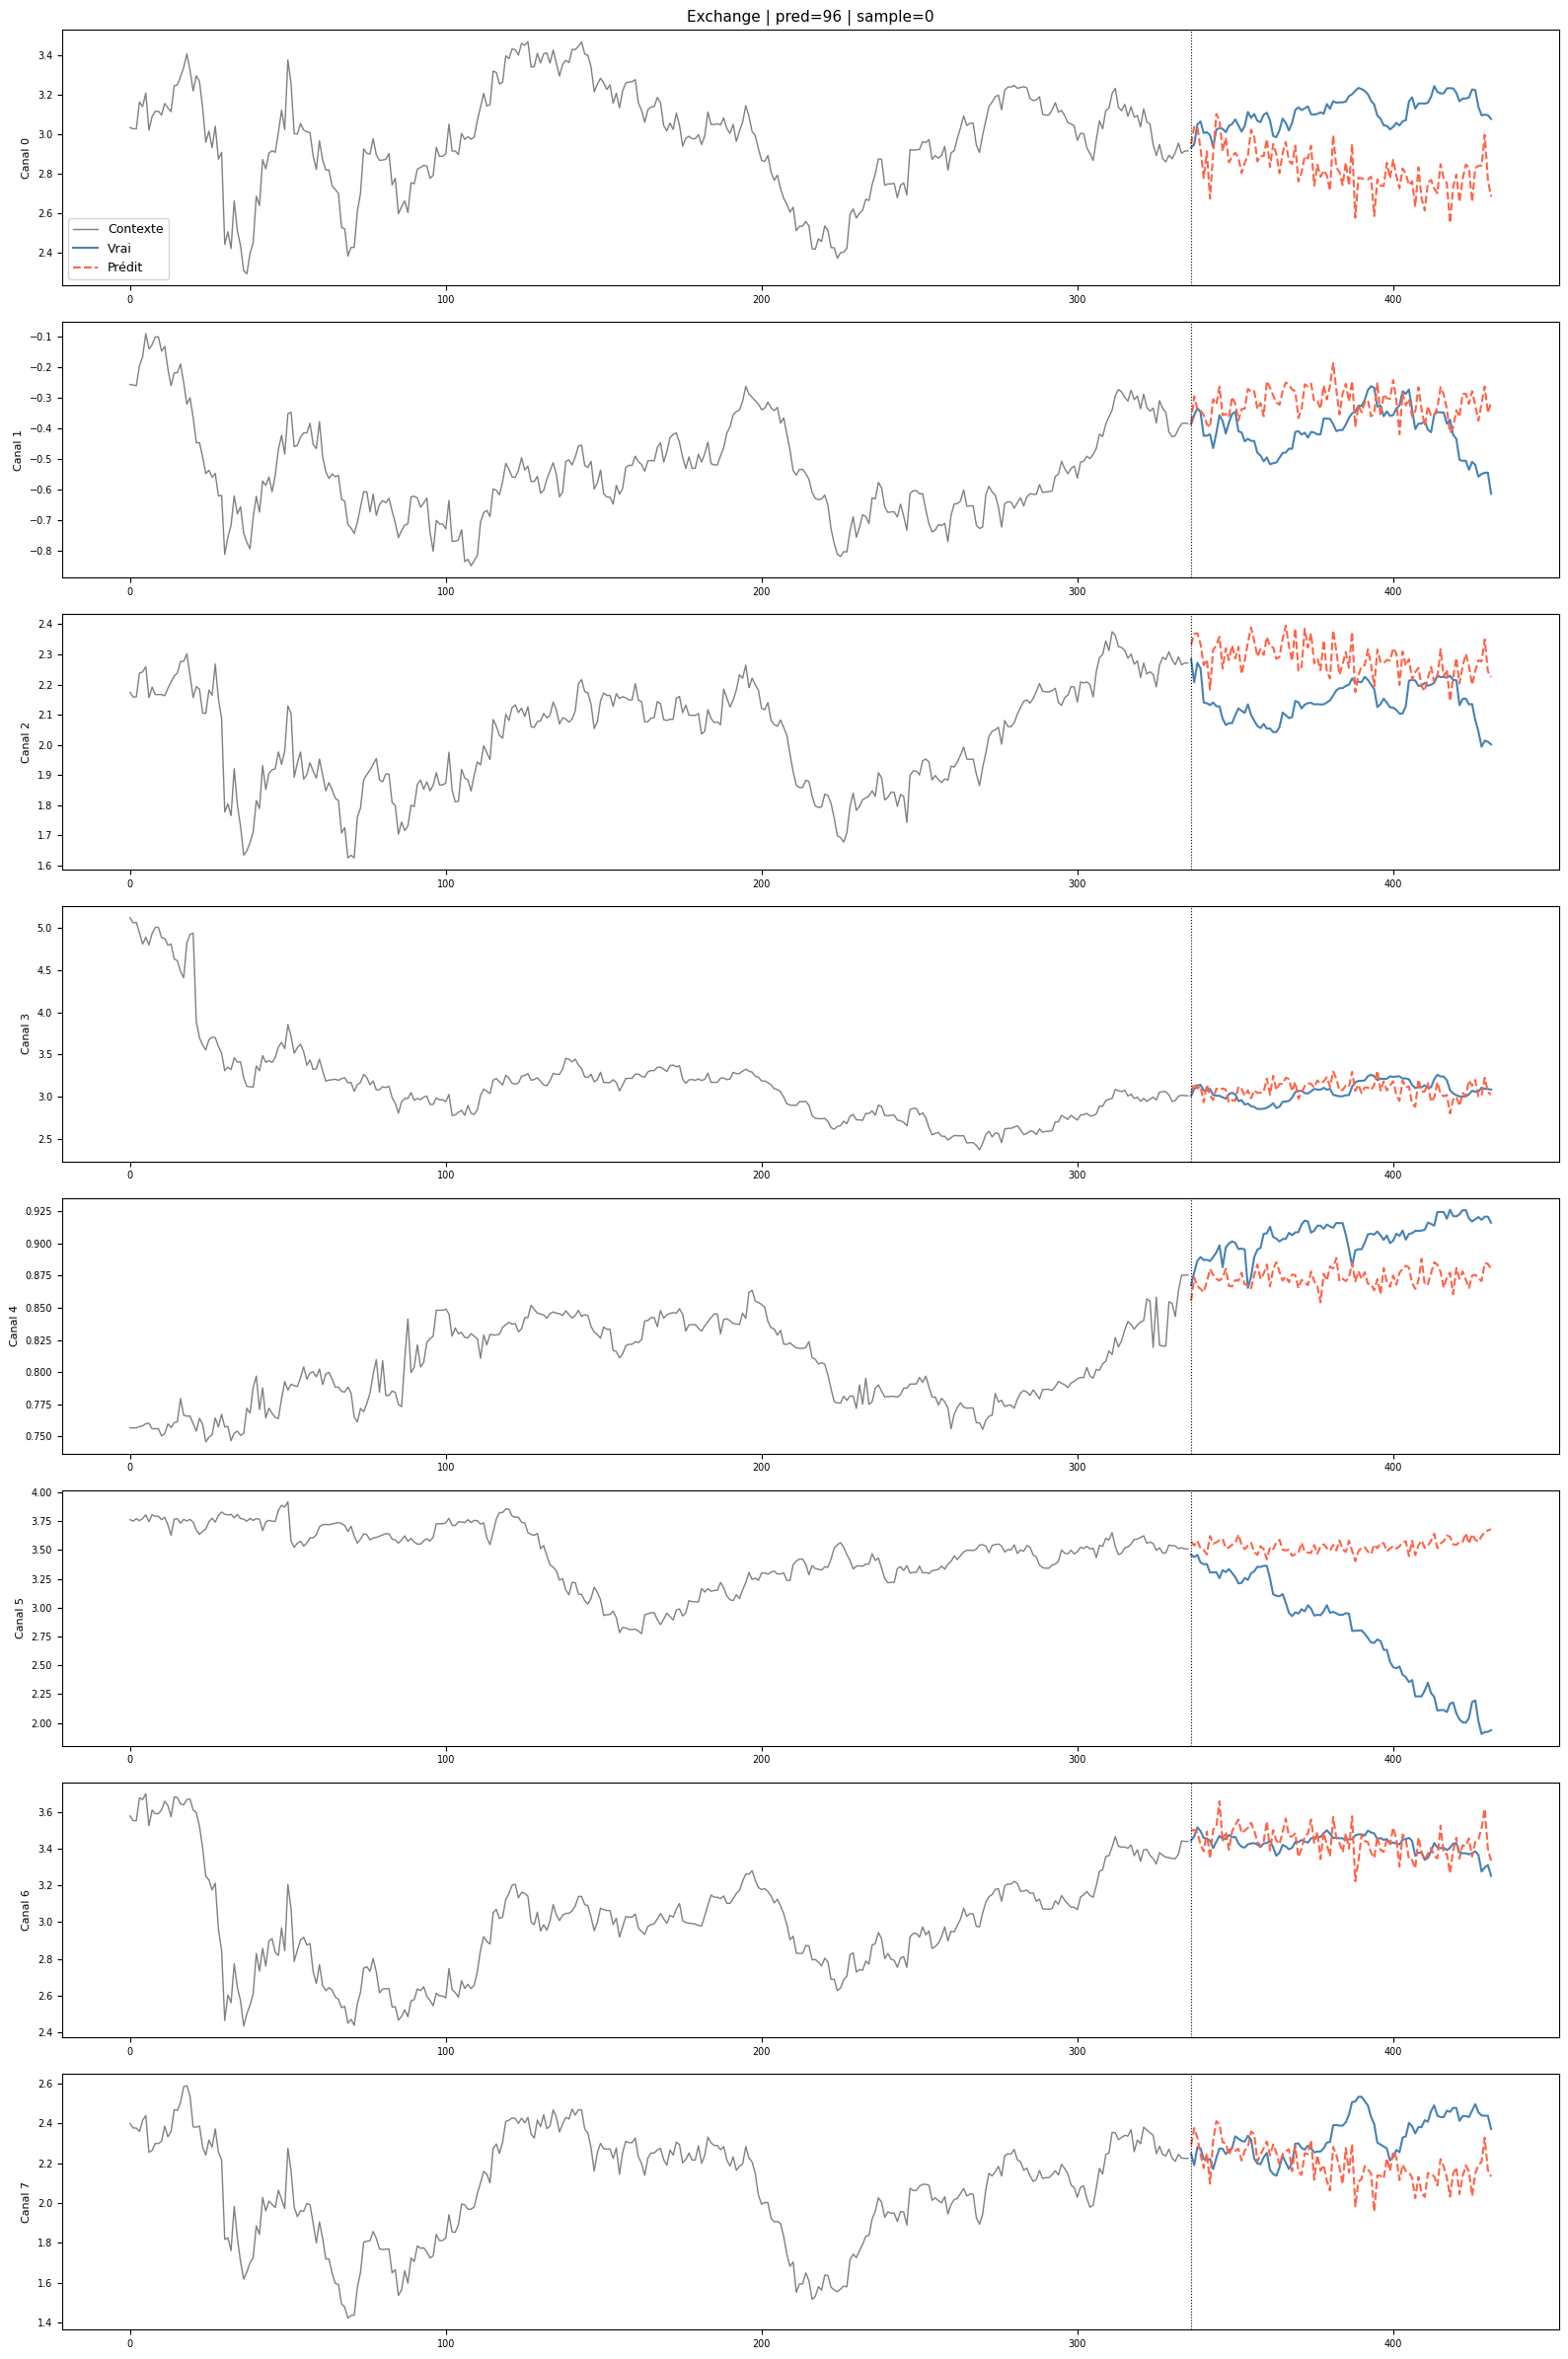

In [13]:
channels = CHANNELS if CHANNELS is not None else list(range(num_channels))
ctx_len  = config.context_length

fig, axes = plt.subplots(len(channels), 1, figsize=(16, 3 * len(channels)), sharex=False)
if len(channels) == 1:
    axes = [axes]

t_ctx  = range(ctx_len)
t_pred = range(ctx_len, ctx_len + PRED_LEN)

for ax, c in zip(axes, channels):
    ax.plot(t_ctx,  x[0, :, c].numpy(),    color="gray",  linewidth=1,   label="Contexte")
    ax.plot(t_pred, y[0, :, c].numpy(),    color="steelblue", linewidth=1.5, label="Vrai")
    ax.plot(t_pred, pred[0, :, c].numpy(), color="tomato", linewidth=1.5, linestyle="--", label="Prédit")
    ax.axvline(ctx_len, color="black", linestyle=":", linewidth=0.8)
    ax.set_ylabel(f"Canal {c}", fontsize=8)
    ax.tick_params(labelsize=7)

axes[0].legend(fontsize=9)
axes[0].set_title(f"{DATASET} | pred={PRED_LEN} | sample={SAMPLE_IDX}", fontsize=11)
plt.tight_layout()
plt.show()